# IPython Notebook for animation

## Importing the required libraries

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output
import  matplotlib.animation as animation

## Set the path/ filename of the file the contains the data

In [10]:
inputfilePath = 'config_output.txt'

## Read the data from the files and save it in lists of floats

In [11]:
e = 1.602176634*1e-19
hbar = 1.054571817*1e-34

plotData = [] #Array to save the real part of the wave functions
with open(inputfilePath,'r') as inputfile:
    for line in inputfile:
        plotData.append(line.strip().split('\t')) #Tab is used as seperator between values
    for j in range(len(plotData)): #Cast list items from string to float type
        plotData[j] = [float(plotData[j][i]) for i in range(len(plotData[0]))] # cast entries to float
    plotData = np.array(plotData) # cast to numpy array

## Generate animation

.....................Done!
.

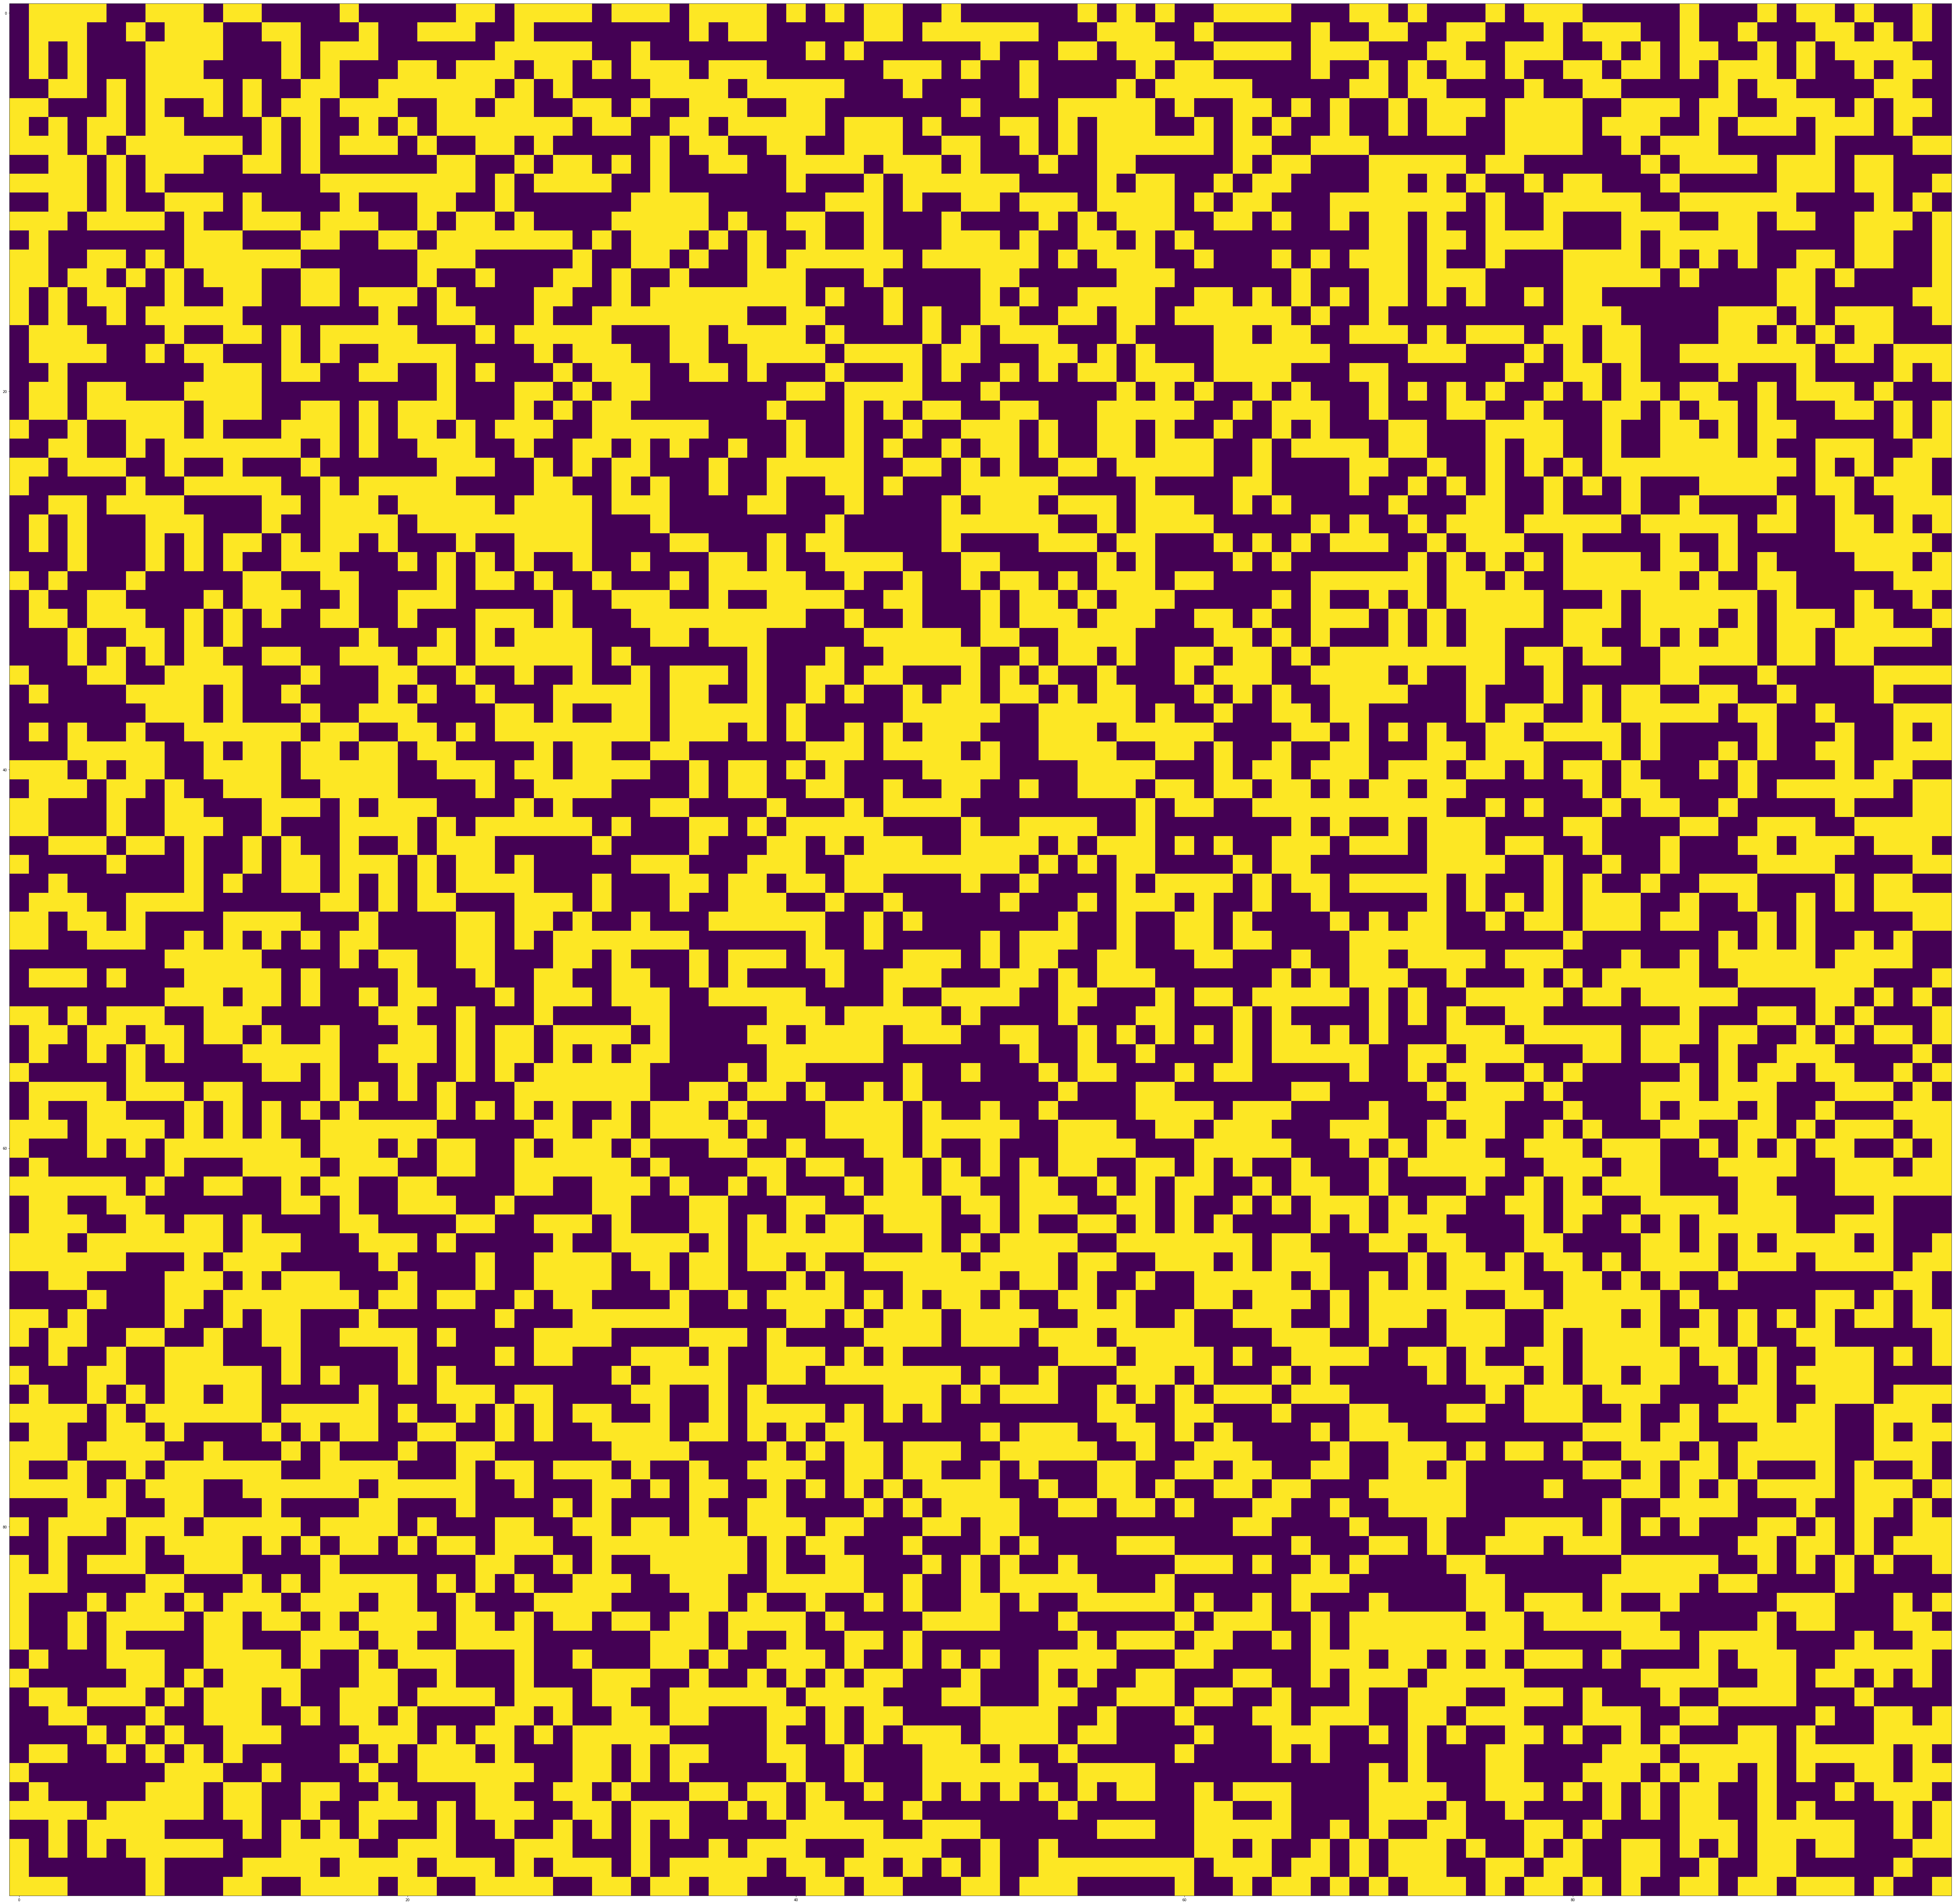

In [13]:
fps = 5
nSeconds = 20

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(100,100) )

plotData = plotData.reshape(fps*nSeconds,100,100)
im = plt.imshow(plotData[0], interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(plotData[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds * fps, interval = 1000 / fps)

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

## Graphical output of the observables
### Valid values for obs are:
###    - "norm-1"  to display the time evolution of the normalisation minus 1
###    - "energy"  to display the time evolution of the energy expectation value
###    - "x"  to display the time evolution of the spacial coordinate expectation value
###    - "p"  to display the time evoltuion of the momentum expectation value
###    - "delta-x"  to display the width of the wave in real space
###    - "delta-p"  to display the width of the wave in momentum space

In [6]:
obs = "energy" # Set the requested observable to plot here

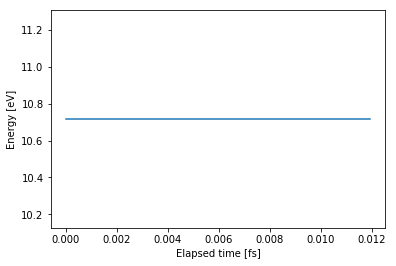

In [7]:
if(obs == "norm-1"):
    plt.plot(obsData[0]*tauhat/omega*1e15,obsData[1])
    plt.xlabel("Elapsed time [fs]")
    plt.ylabel("Absolute deviation from 1")
    plt.show()
    
elif(obs == "energy"):
    plt.plot(obsData[0]*tauhat/omega*1e15,obsData[2]*epsilon/e)
    plt.xlabel("Elapsed time [fs]")
    plt.ylabel("Energy [eV]")
    plt.show()
    
elif(obs == "x"):
    plt.plot(obsData[0]*tauhat/omega*1e15,obsData[3]*a*1e10)
    plt.xlabel("Elapsed time [fs]")
    plt.ylabel("x expectation value [Å]")
    plt.show()
    
elif(obs == "p"):
    plt.plot(obsData[0]*tauhat/omega*1e15,obsData[4]*hbar/a)
    plt.xlabel("Elapsed time [fs]")
    plt.ylabel("p expectation value [kg*m/s]")
    plt.show()
    
elif(obs == "delta-x"):
    plt.plot(obsData[0]*tauhat/omega*1e15,obsData[5]*a*1e10)
    plt.xlabel("Elapsed time [fs]")
    plt.ylabel("x width of the wave function [Å]")
    plt.show()
    
elif(obs == "delta-p"):
    plt.plot(obsData[0]*tauhat/omega*1e15,obsData[6]*hbar/a)
    plt.xlabel("Elapsed time [fs]")
    plt.ylabel("momentum width of the wave function [kg*m/s]")
    plt.show()
    
else:
    print("Invalid value!")